<a href="https://www.kaggle.com/tuhao911/cnn-osic-pulmonary-fibrosis-progression?scriptVersionId=85581697" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pydicom
from tqdm import tqdm

from PIL import Image

In [2]:
Path = "../input/osic-pulmonary-fibrosis-progression"
df_train= pd.read_csv(f"{Path}/train.csv")
df_train.drop_duplicates(keep=False, inplace=True,subset=['Patient','Weeks'])
df_test= pd.read_csv(f"{Path}/test.csv")
Patient_list= df_train["Patient"].unique()

100%|██████████| 71/71 [00:03<00:00, 23.43it/s]


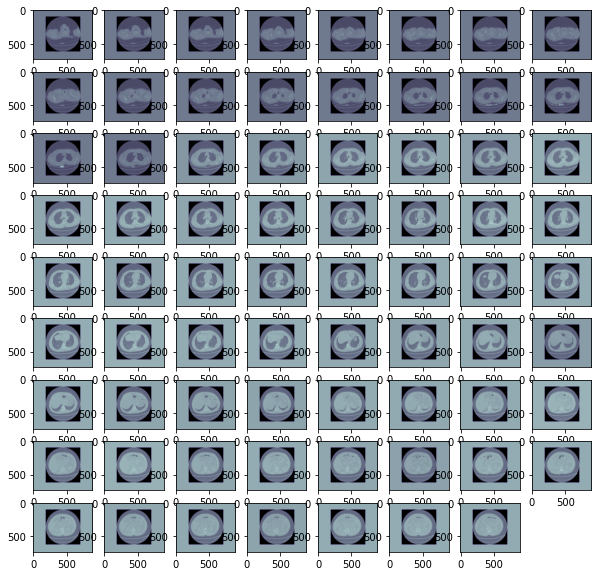

In [3]:
def getDcms(patient,type):
    image_dir = f"{Path}/{type}/{patient}"
    fig=plt.figure(figsize=(10,10))
    image_list = os.listdir(image_dir)
    columns = int(np.sqrt(len(image_list)))
    rows = columns+1
    dcms=[]
    for i in tqdm(range(1, len(image_list) +1)):
        ds = pydicom.dcmread(image_dir + "/" + str(i) + ".dcm")
        dcms.append(ds.pixel_array)
        fig.add_subplot(rows,columns,i)
        plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    return dcms

list=getDcms(Patient_list[50],"train" )

In [4]:
df_train

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker
...,...,...,...,...,...,...,...
1544,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked
1545,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked
1546,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked
1547,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked


In [5]:
def get_Weeks_Dcms(type):
    fig=plt.figure(figsize=(10,10))
    dcms=[]
    plist=[]
    wlist=[]
    for p in tqdm(Patient_list):
        image_dir = f"{Path}/{type}/{p}"
        week=df_train[df_train["Patient"]==p]["Weeks"]
        for w in week:
            try:
                ds = pydicom.dcmread(image_dir + "/" + str(w) + ".dcm")
                dcms.append(ds.pixel_array)
                plist.append(p)
                wlist.append(w)
            except:
                pass
    data = pd.DataFrame({"Patient":plist,"Weeks":wlist})        
    return dcms,data

In [6]:
x_train,train_data=get_Weeks_Dcms("train")

100%|██████████| 176/176 [00:19<00:00,  8.83it/s]


<Figure size 720x720 with 0 Axes>

In [7]:
for i in range(0,len(x_train)):
    im = Image.fromarray(x_train[i])
    im = im.resize((128,128),resample=Image.NEAREST) 
    x_train[i] = np.array(im).reshape((128,128,1))
    #x_train[i] = np.array(im)
    
x_train=np.array(x_train)
train_data = pd.merge(train_data,df_train, how="left", on=['Patient',"Weeks"])

In [8]:
train_data["Sex"]=train_data["Sex"].astype("category").cat.codes
train_data["SmokingStatus"]=train_data["SmokingStatus"].astype("category").cat.codes

<h3><font color=red>Min-Max Normalization </font> <h3>

In [9]:
train_data["Weeks"]=(train_data['Weeks'] - train_data['Weeks'].min() ) / ( train_data['Weeks'].max() - train_data['Weeks'].min() )
train_data["Percent"]=(train_data['Percent'] - train_data['Percent'].min() ) / ( train_data['Age'].max() - train_data['Percent'].min() )
train_data["Age"]=(train_data['Age'] - train_data['Age'].min() ) / ( train_data['Age'].max() - train_data['Age'].min() )

In [10]:
train_data

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,0.034783,2214,0.453881,0.769231,1,1
1,ID00007637202177411956430,0.052174,2061,0.388762,0.769231,1,1
2,ID00007637202177411956430,0.069565,2144,0.424088,0.769231,1,1
3,ID00007637202177411956430,0.086957,2069,0.392167,0.769231,1,1
4,ID00007637202177411956430,0.139130,2101,0.405786,0.769231,1,1
...,...,...,...,...,...,...,...
1226,ID00426637202313170790466,0.104348,2712,0.637948,0.615385,1,2
1227,ID00426637202313170790466,0.156522,2978,0.748427,0.615385,1,2
1228,ID00426637202313170790466,0.260870,2908,0.719354,0.615385,1,2
1229,ID00426637202313170790466,0.365217,2975,0.747181,0.615385,1,2


In [11]:
y=train_data["FVC"].values
feature=train_data[['Weeks','Percent','Age','Sex',"SmokingStatus"]].values

 <h3><font color=red>Min-Max Normalization </font> <h3>

In [12]:
x_min = np.min(x_train)
x_max = np.max(x_train)
xs = x_train - x_min / (x_max - x_min)

In [13]:
y.shape,feature.shape,xs.shape,x_train.shape

((1231,), (1231, 5), (1231, 128, 128, 1), (1231, 128, 128, 1))

In [14]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

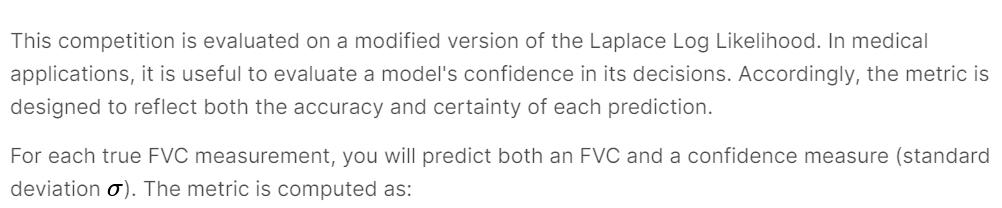

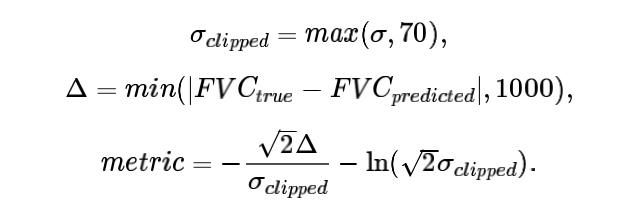

In [15]:
C70, C10 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")
#=============================#
def LaplaceLogLikelihood(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    
    sigma_clip = tf.maximum(y_pred[:, 1], C70)
    
    delta = tf.minimum(tf.abs(y_true[:, 0] - y_pred[:, 0]), C10)
  
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)
#=============================#
def regressionloss (y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    spread = tf.abs( (y_true[:, 0] -  y_pred[:, 0])  / y_true[:, 0] )
    #spred = tf.square(y_true, y_pred[:, 0])
    return K.mean(spread)
#=============================#

def OSICloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * LaplaceLogLikelihood(y_true, y_pred) + (1 - _lambda)*regressionloss(y_true, y_pred)
    return loss
#=================

2022-01-19 03:25:28.769673: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 03:25:28.854712: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 03:25:28.855441: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 03:25:28.857994: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [16]:
def model_2D():
    ct = L.Input((128,128,1),name="Ctinput")  
    Patint = L.Input((5,), name="Patient" ) 
    x =L.Conv2D(64,(6,6),activation="relu",name="conv1")(ct)
    x =L.MaxPooling2D(pool_size=(3,3), name='pool1')(x)
    
    x = L.Conv2D(64,(6,6),activation="relu",name="conv2")(x)
    x = L.MaxPooling2D(pool_size=(3,3), name='pool2')(x)
    
    x = L.Conv2D(128,(6,6),activation="relu",name="conv3")(x)
    x = L.MaxPooling2D(pool_size=(2,2), name='pool3')(x)
    
    x = L.Flatten(name="features")(x)
    x = L.Dense(64, activation="relu", name="d1")(x)
    P = L.Dense(32, activation="relu", name="d2")(Patint)
    x = L.Concatenate(name="combine")([x, P])
    x = L.Dense(32, activation="relu", name="d3")(x)
    preds = L.Dense(2, activation="relu", name="preds")(x)
    
    model = M.Model([ct, Patint], preds, name="CNN")
    model.compile(loss=OSICloss(0.5), optimizer="adam", metrics=[LaplaceLogLikelihood])
    
    return model

In [17]:
net_2D = model_2D()
print(net_2D.summary())

Model: "CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Ctinput (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 123, 123, 64) 2368        Ctinput[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 41, 41, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 36, 36, 64)   147520      pool1[0][0]                      
________________________________________________________________________________________________

In [18]:
y.shape,feature.shape,xs.shape,x_train.shape

((1231,), (1231, 5), (1231, 128, 128, 1), (1231, 128, 128, 1))

In [19]:
y=y.astype("float32")

In [20]:
net_2D.fit([x_train, feature], y, batch_size=50, epochs=100)

2022-01-19 03:25:32.105229: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-01-19 03:25:34.511227: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


25/25 [==============================] - 8s 23ms/step - loss: 5.0646 - LaplaceLogLikelihood: 9.5401
Epoch 2/100
25/25 [==============================] - 0s 18ms/step - loss: 4.8386 - LaplaceLogLikelihood: 9.1865
Epoch 3/100
25/25 [==============================] - 0s 18ms/step - loss: 4.5544 - LaplaceLogLikelihood: 8.6897
Epoch 4/100
25/25 [==============================] - 0s 17ms/step - loss: 4.3275 - LaplaceLogLikelihood: 8.3296
Epoch 5/100
25/25 [==============================] - 0s 18ms/step - loss: 4.2650 - LaplaceLogLikelihood: 8.2027
Epoch 6/100
25/25 [==============================] - 0s 18ms/step - loss: 4.2437 - LaplaceLogLikelihood: 8.1855
Epoch 7/100
25/25 [==============================] - 0s 18ms/step - loss: 4.2015 - LaplaceLogLikelihood: 8.1110
Epoch 8/100
25/25 [==============================] - 0s 18ms/step - loss: 4.2168 - LaplaceLogLikelihood: 8.1445
Epoch 9/100
25/25 [==============================] - 0s 18ms/step - loss: 4.1634 - LaplaceLogLikelihood: 8.0536
Epoc

In [21]:
def model_1D():
    ct = L.Input((128,128), name="input")
    Patint = L.Input((5,), name="Patient")
    x = L.Conv1D(50, 4, activation="relu", name="conv1")(ct)
    x = L.MaxPool1D(2, name='pool1')(x)
    
    
    x = L.Conv1D(50, 4, activation="relu", name="conv2")(x)
    x = L.MaxPool1D(2, name='pool2')(x)
    
  
    x = L.Conv1D(50, 4, activation="relu", name="conv3")(x)
    x = L.MaxPool1D(2, name='pool3')(x)
    
    x = L.Flatten(name="features")(x)
    x = L.Dense(50, activation="relu", name="d1")(x)
    l = L.Dense(10, activation="relu", name="d2")(Patint)
    x = L.Concatenate(name="combine")([x, l])
    x = L.Dense(50, activation="relu", name="d3")(x)
    preds = L.Dense(2, activation="relu", name="preds")(x)
    
    model = M.Model([ct, Patint], preds, name="CNN")
    model.compile(loss=OSICloss(0.5), optimizer="adam", metrics=[LaplaceLogLikelihood])
   
    return model

In [22]:
net_1D = model_1D()
print(net_1D.summary())

Model: "CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 128, 128)]   0                                            
__________________________________________________________________________________________________
conv1 (Conv1D)                  (None, 125, 50)      25650       input[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling1D)            (None, 62, 50)       0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv1D)                  (None, 59, 50)       10050       pool1[0][0]                      
________________________________________________________________________________________________

In [23]:
y.shape,feature.shape,xs.shape,x_train.shape

((1231,), (1231, 5), (1231, 128, 128, 1), (1231, 128, 128, 1))

In [24]:
y=y.astype("float32")

In [25]:
net_1D.fit([xs, feature], y, batch_size=50, epochs=100) #, validation_split=0.1

Epoch 1/100
25/25 [==============================] - 1s 8ms/step - loss: 4.6408 - LaplaceLogLikelihood: 8.8072
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 4.2221 - LaplaceLogLikelihood: 8.1332
Epoch 3/100
25/25 [==============================] - 0s 5ms/step - loss: 4.1846 - LaplaceLogLikelihood: 8.0854
Epoch 4/100
25/25 [==============================] - 0s 5ms/step - loss: 4.1494 - LaplaceLogLikelihood: 8.0381
Epoch 5/100
25/25 [==============================] - 0s 8ms/step - loss: 4.1086 - LaplaceLogLikelihood: 7.9718
Epoch 6/100
25/25 [==============================] - 0s 7ms/step - loss: 4.1040 - LaplaceLogLikelihood: 7.9672
Epoch 7/100
25/25 [==============================] - 0s 6ms/step - loss: 4.0822 - LaplaceLogLikelihood: 7.9267
Epoch 8/100
25/25 [==============================] - 0s 6ms/step - loss: 4.1238 - LaplaceLogLikelihood: 7.9995
Epoch 9/100
25/25 [==============================] - 0s 7ms/step - loss: 4.0751 - LaplaceLogLikelihood: 7.9158
E

In [26]:
predict_2D=net_2D.predict([xs, feature], batch_size=100, verbose=1)

13/13 [==============================] - 0s 9ms/step


In [27]:
predict_1D=net_1D.predict([xs, feature], batch_size=100, verbose=1)

13/13 [==============================] - 0s 5ms/step


In [28]:
 pdata_2D = pd.DataFrame({"FVC":predict_2D[:,0],"CON":predict_2D[:,1]})    

In [29]:
 pdata_1D = pd.DataFrame({"FVC":predict_1D[:,0],"CON":predict_1D[:,1]})   

In [30]:
pdata_2D

,FVC,CON
0,2143.918213,157.085648
1,2021.021729,168.048721
2,2378.724365,297.252075
3,2053.868896,212.719345
4,2054.387451,169.774490
...,...,...
1226,2842.795654,238.230148
1227,3038.551514,231.863724
1228,2988.290771,243.582626
1229,2908.821045,251.287857


In [31]:
pdata_1D

,FVC,CON
0,2187.795410,211.395706
1,1959.326904,195.022461
2,2129.672607,195.129608
3,2076.282715,199.937927
4,2090.884277,205.798859
...,...,...
1226,2585.098877,190.683258
1227,2724.162109,198.706314
1228,2814.404053,205.214355
1229,2836.797119,202.632111
